In [1]:
import keras
import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Activation, Flatten, Dense
from keras.layers.normalization import BatchNormalization

from keras.datasets import mnist
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
def mnist_generator():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    train_dict = defaultdict(lambda: [])
    for i in range(len(x_train)):
        train_dict[y_train[i]].append(x_train[i])
    for keys in train_dict:
        train_dict[keys] = np.array(train_dict[keys])
    labels = np.arange(9)
    
    while(True):
        
        sample = np.random.choice(labels, 6, replace=False)
        p_choices =np.random.choice(len(train_dict[sample[0]])-1, 10, replace=False)
        n_choices =[np.random.choice(len(train_dict[sample[i]])-1, 1, replace=False)[0] for i in range(1, 6)]
        
        positive_image = train_dict[sample[0]][p_choices].reshape(10, 28, 28, 1)
        negative_image = np.array([train_dict[sample[i]][n_choices[i-1]] for i in range(1, 6)]).reshape(5, 28, 28, 1)
        
        
        y = [sample[0] for i in range(10)]
        for i in range(1, 6):
            y.append(sample[i])
#         print(np.vstack((positive_image / 255., negative_image / 255.)).shape, y.shape)
        yield np.vstack((positive_image / 255., negative_image / 255.)), np.array(y)
        

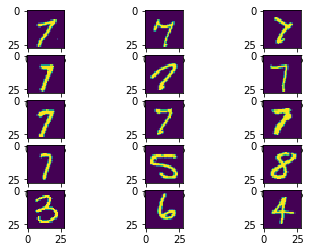

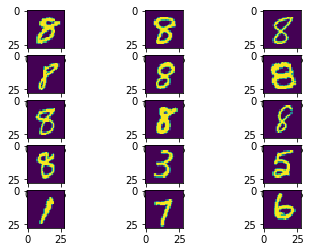

In [8]:
# Visualize the generator mini batch, expect to see 10 sample which same class and 5 sample from different class
k = 0
x_ = None
columns = 3
rows = 5
for train, labels in mnist_generator():
    k += 1
    if k >= 3:
        break
    # Show random images
    x_ = train

    fig=plt.figure()

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x_[i-1].reshape(28, 28))
    plt.show()

In [9]:
def triplets_loss(y_true, y_pred):
    
#     embeddings = K.cast(embeddings, 'float32')
#     with sess.as_default():
#         print(embeddings.eval())
    
    embeddings = y_pred
    anchor_positive = embeddings[:10]
    negative = embeddings[10:]
#     print(anchor_positive)

    # Compute pairwise distance between all of anchor-positive
    dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
    square = K.square(anchor_positive)
    a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
    a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
#     with K.get_session().as_default():
#         print(a_p_distance.eval())
#     print("Pairwise shape: ", a_p_distance)
#     print("Negative shape: ", negative)

    # Compute distance between anchor and negative
    dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
    negative_square = K.square(negative)
    a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
    a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
    
    hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
    
    distance = (a_p_distance - hard_negative + 0.2)
    loss = K.mean(K.maximum(distance, 0.0))/(2.)

#     with K.get_session().as_default():
#             print(loss.eval())
            
    return loss

In [10]:
# Sanity check the implementation
test_batch = np.random.rand(15, 128)
test_batch
with K.get_session().as_default():
        print(triplets_loss(None, tf.convert_to_tensor(test_batch)).eval())
            






1.358535847901044


In [11]:
# declare a simple CNN network
def baseline_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32))
    # Compile model
    optim = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    model.compile(loss=triplets_loss, optimizer=optim)
    model.summary()
    return model

In [12]:
model = baseline_model()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_______________________

In [13]:
model.fit_generator(mnist_generator(), steps_per_epoch=5000, epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
5000/5000 [==============================] - 114s 23ms/step - loss: 0.2423
Epoch 2/10
5000/5000 [==============================] - 113s 23ms/step - loss: 0.0114
Epoch 3/10
5000/5000 [==============================] - 113s 23ms/step - loss: 0.0073
Epoch 4/10
5000/5000 [==============================] - 113s 23ms/step - loss: 0.0056
Epoch 5/10
5000/5000 [==============================] - 114s 23ms/step - loss: 0.0045
Epoch 6/10
5000/5000 [==============================] - 116s 23ms/step - loss: 0.0036
Epoch 7/10
5000/5000 [==============================] - 127s 25ms/step - loss: 0.0031
Epoch 8/10
5000/5000 [==============================] - 131s 26ms/step - loss: 0.0027
Epoch 9/10
5000/5000 [==============================] - 127s 25ms/step - loss: 0.0026
Epoch 10/10
5000/5000 [==============================] - 129s 26ms/step - loss: 0.0022


In [14]:
tsne = TSNE()


In [15]:
choices = np.random.choice(np.arange(len(x_test)), len(x_test), replace=False)

In [16]:
x_sample, y_sample = x_test[choices], y_test[choices]

In [17]:
embeddings = model.predict(x_sample.reshape((len(x_sample), 28, 28, 1)))

In [18]:
embeddings.shape

(10000, 32)

(10000, 2)
(10000,)


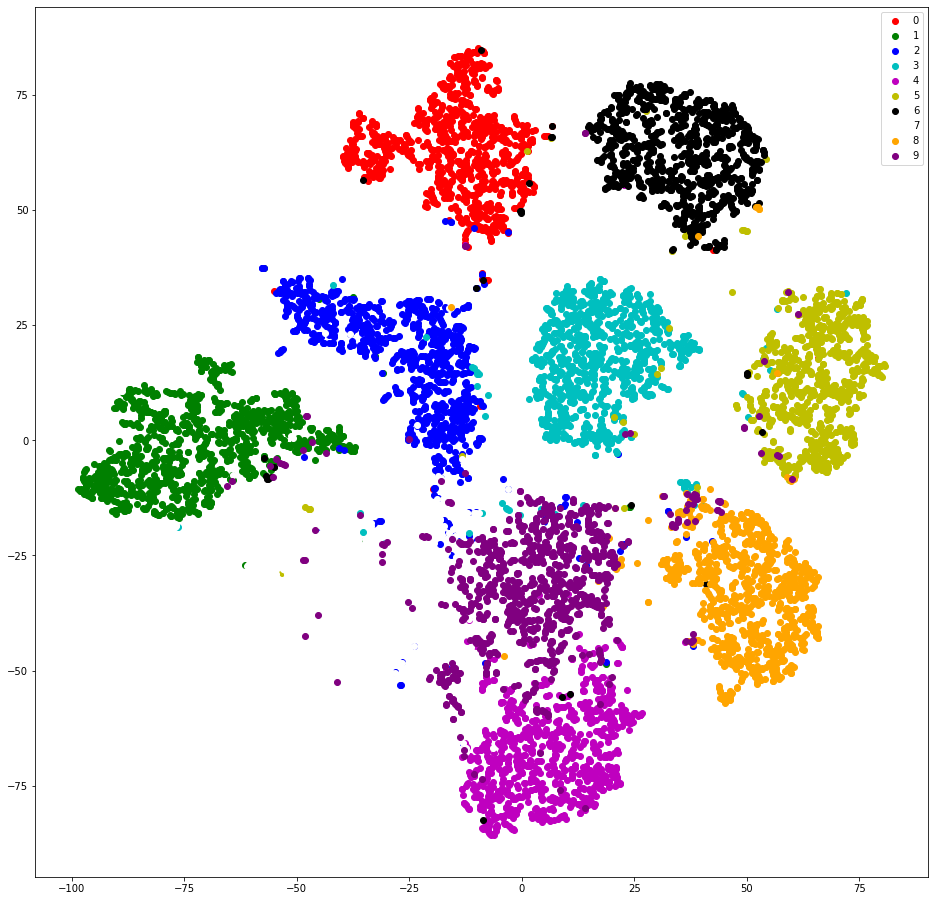

In [27]:
tsne_train = tsne.fit_transform(embeddings)
print(tsne_train.shape) 
print(y_sample.shape) 
plt.figure(figsize=(16, 16))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c in zip(range(10), colors):
    plt.scatter(tsne_train[y_sample == i, 0], tsne_train[y_sample == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [35]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [36]:
embeddings

array([[  9.766879 ,   2.4667377,  -3.4543223, ...,  39.66214  ,
          7.1973042, -11.256141 ],
       [ 14.945268 ,   2.3569076,  -2.0492063, ..., 108.11213  ,
         -4.160202 , -11.888586 ],
       [ 11.426653 ,   2.5431507,  -5.426624 , ..., -42.757915 ,
         -1.6587995, -22.045305 ],
       ...,
       [ 15.417338 ,   3.4154654,  -0.8963618, ..., 125.634964 ,
         -2.4871352, -14.625878 ],
       [  1.7823939,   3.1414275,  -2.995408 , ...,  -6.156292 ,
         -3.9015124, -13.829766 ],
       [ 38.98281  , -13.984033 , -25.708675 , ...,  74.072395 ,
        -77.000755 ,   8.462226 ]], dtype=float32)